# Before starting
## Open in notebook viewer to see the [online version](http://nbviewer.jupyter.org/github/puccife/ADAHomeworks/blob/master/homework03/homework03.ipynb)

Be sure that you have already installed the following libraries. In particular:
- **geopy**, used to obtain location of a geographical address
- **branca**, used to create a custom figure with multiple sub-figures.

In [146]:
import os
import pandas as pd
import json
import folium
import re
from numpy import interp
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from folium.plugins.measure_control import MeasureControl
from folium import plugins
import branca
from IPython.display import IFrame

## Common function for all tasks

### Adding cloropleth to map
Function used to add a  cloropleth map based on:
- dataframe that contains the values that we want to represent on the cloroplet
- map, where to add the cloropleth map
- key, used to match cloropleth map ids

In [147]:
def addCloropleth(dataframe, map_, feature, legend_name, key, scale_color,json_data,object_):
    map_.choropleth(geo_data=json_data,
             data=dataframe,
             columns=[key, feature],
             key_on='feature.id',
             fill_color=scale_color, 
             fill_opacity=0.5, 
             line_opacity=0.2,
             highlight=True,
             legend_name=legend_name, topojson = object_)

## Task 1

## Datasets and topojson files
- **europe.topojson.json** - Contains the european countries abbreviations and arcs
- **tepsr_wc170.tsv** - Dataset we are using for european unemployment rates

In [148]:
europe_topo_path = './topojson/europe.topojson.json'
path = './datasets/tepsr_wc170.tsv'
object_europe = 'objects.europe'
geolocator = Nominatim()

### About the dataset
We choose this dataset in particular because it had unemployment rate values for Switzerland.


The dataset describes the unemployment rate based on the **EU Labour force** survey, where the unemployment rate represents unemployed persons as a percentage of the labour force and the labour force is the total number of people employed and unemployed.
The dataset is divided into several **age categories**:

- 15-24 Years old. 
- 15-74 Years old, which represents all the age margins.
- 20-64 Years old
- 25-29 Years old
- 25-54 Years old
- 55-64 Years old

Furthermore, we have unemployment rate starting from 2005 upto 2016.

The countries available in the dataset are :

- The 28 European Union countries.
- 3 of the European Free Trade Association (EFTA) [ **Liechtenstein** is not avialable ].
- 2 of the EU candidate countries, in particular [ **Turkey**, **The former Yugoslav Republic of Macedonia** ].


## Loading json files and dataset

In [149]:
topo_json_data = json.load(open(europe_topo_path))
df = pd.read_csv(path,sep=',|\t',engine='python')

## Functions used for Task 1
### Changing values from string to float

In the dataset the columns that contain the unemployment rates are strings and some of them have letters included.
This function takes the strings in the unemployment rate column and extracts the float number and returns a list of float numbers containting the unemployment rates.

In [150]:
def string_to_float(unemployment_pc_act):
    float_list = []
    # Extracting all the unemployment rates with type string into a list
    string_list = list(unemployment_pc_act['Unemployment Rate'])
    # Splitting the number from letter in the string, for example from '4.6 b' to '4.6' .
    for value in string_list:
        float_list.extend((re.findall("\d+\.\d+", value)))
    float_list = [float(i) for i in float_list]
    return float_list

### Cleaning the dataframe

Through this function we will be able to pick a certain year and a certain age category to be used in the map.
The output would be a dataframe that contains the abbreviation of the country as index, Age range and Unemployment Rate.

Some refinements are made regarding the abbreviations of 2 specific countries [ **United Kingdom**, and **Greece** ] from [ **EL , UK** to **GR , GB** ]  to match the abbreviations found in the topojson file.

The unemployment rate column is changed to float using the function described above.


In [151]:
def cleanDataframe_1(df,year,age):
    
    # Setting index to the dataframe and using only the columns set to the criteria passed in the function.
    df = df.set_index('geo\\time')
    extracted_columns = str('age') + '|' + str(year)
    unemployment_pc = df.filter(regex = (extracted_columns))
    unemployment_pc.index.names=['Abreviations']
    unemployment_pc.columns=['Age Range','Unemployment Rate']
    unemployment_pc_act = unemployment_pc[unemployment_pc['Age Range']== age]
    
    # Changing UK and EL to GR and GB to match the topojson file.
    indexes = unemployment_pc_act.index.tolist()
    idx_1 = indexes.index('EL')
    idx_2 = indexes.index('UK')
    indexes[idx_1] = 'GR'
    indexes[idx_2] = 'GB'
    unemployment_pc_act.index = indexes
    unemployment_pc_act.index.name = 'Abreviations'
    
    # Cleaning the unemployment rate column and changing it to float data type column.
    unemployment_rate = string_to_float(unemployment_pc_act)
    unemployment_pc_act = unemployment_pc_act.drop('Unemployment Rate',axis=1)
    unemployment_pc_act['Unemployment Rate'] = unemployment_rate
    
    return unemployment_pc_act

 

### Extracting european countries and their abreviations from topojson
The europe.topojson file contains 51 countries with their abbreviations. This function extracts the name of the country with the corresponding abbreviation given to it inside the topojson.

In [152]:
def europe_abreviations(topo_json_data):
    
    europe_countries = pd.DataFrame()
    # Extracting country names from the topojson file and adding it to the dataframe.
    europe_countries['Country'] = [country['properties']['NAME'] for country in topo_json_data['objects']['europe']['geometries']]
    # Extracting country abbreviations from the topojson file and adding it to the dataframe.
    europe_countries['Abreviations'] = [abrv['id'] for abrv in topo_json_data['objects']['europe']['geometries']]
    # Setting dataframe index to the abbreviations of the countries.
    europe_countries = europe_countries.set_index('Abreviations')
    return europe_countries


### Creating HTML popup

In [153]:
def getHtml(location_name, rate_value, label):
    return """
    <style>
    h3 {
        color: blue;
        text-align: center;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    h5 {
        text-align: left;
        font-family: verdana;
        font-size: 12px;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    </style>
    <h3> """ + location_name + """</h3><br>
    <h4>
        """+ label +""": <em>"""+ rate_value +""" </em>
    </h4>
    """

### Creating the dataframe to be used in the folium map
In here we merge both the dataframe that includes all of our unemployment rate data and the one that includes the european countries with their abbreviations.

The output would contain only the countries that are listed in both dataframes, excluding the unnecessary data.
We also return a list of the abbreviations of the countries included in that dataframe to be used to clean the topojson file.

In [154]:
def abreviations_rate(dataframe_1,dataframe_2):
    
    # Joining the dataset dataframe and the country/abbreviations.
    country_rate = dataframe_1.join(dataframe_2)
    # Remove the countries that aren't present in the dataset.
    country_rate = country_rate[country_rate['Country'].notnull()]
    #abrv_rate = country_rate['Unemployment Rate'].to_frame()
    abreviations = list(country_rate.index.values)
    # Returning the dataframe that is going to be used in the map.
    country_rate = country_rate.reset_index()
    country_rate = country_rate.drop('Age Range',axis=1)
    return abreviations,country_rate

###  Cleaning topojson to contain only european countries
As mentioned before the europe.topojson file contains 51 countries.
Since we need only to have the european countries listed in our dataset for our map, we remove the countries that are not listed in the output of the dataframe created above using the abbreviations we extracted.

In [155]:
def clean_topojson(topo_json_data,abreviations):
    new_list = []
    # Extracting the country data we need that are only present in our dataset, using the list of country
    # abbreviations we got above.
    topo_data = topo_json_data
    new_list [:] = [ country for country in topo_data['objects']['europe']['geometries'] if country['id'] in abreviations]
    topo_data['objects']['europe']['geometries'] = new_list
    return topo_data

### Adding Markers to map
Function used to add Circular markers to the map.
- for each country we obtain its latitude and longitude.
- at this latitude and longitude we plot a circleMarker.
- this marker has a html popup displaying the informations related to the country.
- the size of the marker is proportional to the rate of the information we are representing. In other words, higher value of unemployement rate = bigger circle.
- we add the markers to a marker cluster.

In [156]:
def addMarkersToMap_(dataframe, map_, key, feature, marker_color, legend_name):
    marker_cluster = MarkerCluster().add_to(map_)
    c = MeasureControl()
    c.add_to(map_)
    for index,row in dataframe.iterrows():
        place = dataframe.at[index,key] + ", " + dataframe.at[index,'Abreviations']
        location = geolocator.geocode(place)
        dataframe.loc[index, 'Latitude'] = location.latitude
        dataframe.loc[index, 'Longitude'] = location.longitude
        html = getHtml(place, str(dataframe.at[index,feature]), legend_name)
        folium.CircleMarker(
            location=[location.latitude, location.longitude],
            radius=dataframe.at[index,feature],
            fill=True,
            fill_color = marker_color,
            color = marker_color,
            popup=folium.Popup(html),
        ).add_to(marker_cluster)

### Folium Maps

In [157]:
europe_map_2016 = folium.Map(location=[51,10], zoom_start=4)
europe_map_2006 = folium.Map(location=[51,10], zoom_start=4)
europe_map_2016_y = folium.Map(location=[51,10], zoom_start=4)
europe_map_2016_o = folium.Map(location=[51,10], zoom_start=4)

### Running the functions listed above to get the detailed map.

You can manipulate the variables year and age_category to get different maps.

### Obtaining data for 2016 of age between 15-74

In [158]:
year = 2016
age_category = 'Y15-74'

# Clean dataframe w.r.t. age category and year.
unemployment_pc_act = cleanDataframe_1(df,year,age_category)
# European country dataframe with abbreviations.
europe_abrv= europe_abreviations(topo_json_data)
# European countries abbreviations and their unemployment rate
abreviations, country_rate = abreviations_rate(unemployment_pc_act,europe_abrv)
# Topojson file containing only the countries present in our dataset
topo_json_data = clean_topojson(topo_json_data,abreviations)

In [159]:
addCloropleth(country_rate,europe_map_2016,'Unemployment Rate','Percentage of Unemployment(%) 2016','Abreviations','YlOrRd',topo_json_data,object_europe)

In [160]:
addMarkersToMap_(country_rate, europe_map_2016, 'Country', 'Unemployment Rate', 'blue', 'Percentage of Unemployment (%) 2016')

### Obtaining data for 2006 of age between 15-74

In [161]:
year = 2006
age_category = 'Y15-74'

# Clean dataframe w.r.t. age category and year.
unemployment_pc_act = cleanDataframe_1(df,year,age_category)
# European country dataframe with abbreviations.
europe_abrv= europe_abreviations(topo_json_data)
# European countries abbreviations and their unemployment rate
abreviations, country_rate = abreviations_rate(unemployment_pc_act,europe_abrv)
# Topojson file containing only the countries present in our dataset
topo_json_data = clean_topojson(topo_json_data,abreviations)

In [162]:
addCloropleth(country_rate,europe_map_2006,'Unemployment Rate','Percentage of Unemployment(%) 2006','Abreviations','YlOrRd',topo_json_data,object_europe)

In [163]:
addMarkersToMap_(country_rate, europe_map_2006, 'Country', 'Unemployment Rate', 'blue', 'Percentage of Unemployment (%) 2006')

### Obtaining data for 2016 of age between 15-24

In [164]:
year = 2016
age_category = 'Y15-24'

# Clean dataframe w.r.t. age category and year.
unemployment_pc_act = cleanDataframe_1(df,year,age_category)
# European country dataframe with abbreviations.
europe_abrv= europe_abreviations(topo_json_data)
# European countries abbreviations and their unemployment rate
abreviations, country_rate = abreviations_rate(unemployment_pc_act,europe_abrv)
# Topojson file containing only the countries present in our dataset
topo_json_data = clean_topojson(topo_json_data,abreviations)

In [165]:
addCloropleth(country_rate,europe_map_2016_y,'Unemployment Rate','Percentage of Unemployment(%) 2016 [15-24]','Abreviations','YlOrRd',topo_json_data,object_europe)

In [166]:
addMarkersToMap_(country_rate, europe_map_2016_y, 'Country', 'Unemployment Rate', 'blue', 'Percentage of Unemployment (%) 2016 [15-24]')

### Obtaining data for 2016 of age between 25-54

In [167]:
year = 2016
age_category = 'Y25-54'

# Clean dataframe w.r.t. age category and year.
unemployment_pc_act = cleanDataframe_1(df,year,age_category)
# European country dataframe with abbreviations.
europe_abrv= europe_abreviations(topo_json_data)
# European countries abbreviations and their unemployment rate
abreviations, country_rate = abreviations_rate(unemployment_pc_act,europe_abrv)
# Topojson file containing only the countries present in our dataset
topo_json_data = clean_topojson(topo_json_data,abreviations)

In [168]:
addCloropleth(country_rate,europe_map_2016_o,'Unemployment Rate','Percentage of Unemployment(%) 2016 [24-54]','Abreviations','YlOrRd',topo_json_data,object_europe)

In [169]:
addMarkersToMap_(country_rate, europe_map_2016_o, 'Country', 'Unemployment Rate', 'blue', 'Percentage of Unemployment (%) 2016 [24-54]')

## Displaying 
Storing the maps in multiple html figures, using **branca**.

In [170]:
f = branca.element.Figure()
d1 = f.add_subplot(1, 2, 1)
d2 = f.add_subplot(1, 2, 2)
d1.add_child(europe_map_2006)
d2.add_child(europe_map_2016)

                            2006                                                      2016  

### Results
Above we have 2 maps, the unemployment rates from 2006 and 2016.
On a larger scale, we can see that most of the countries had a lower unemployment rate in 2006 than 2016.

Iceland is the country with the least rate in 2006 and 2016 with 2.8% and 3.0% respectively.

Macedonia shows a great improvement from 36.1% to 23.7%.

In 2006, Switzerland had 4% unemployment rate, ranking 5th between all the displayed countries where Iceland, Norway, Netherlands, and Denmark topped the ranks respectively with around the 1% margin.

In 2016, Switzerland had 5% unemployment rate, ranking 7th between all the displayed countries where Iceland, Czech Republic, Germany, Malta, Norway, and the United Kingdom topped the ranks respectively with around the 2% margin.

A lot of factors effect the unemployment rate such as the Economical growth of a country or the technological sector advancements.

We can clearly notice that Greece went from 9.0% unemployment rate to 23.6% in a decade due to the financial crisis of 2007.

In [171]:
f2 = branca.element.Figure()
d3 = f2.add_subplot(1, 2, 1)
d4 = f2.add_subplot(1, 2, 2)
d3.add_child(europe_map_2016_y)
d4.add_child(europe_map_2016_o)

                       [15-24] Years                                               [25-54] Years

### Results
Above we have 2 maps, the unemployment rates of 2016 for 2 different age groups.
- 15-24
- 24-54

Comparing both scales on the map we can directly indicate that the younger population [15-24] is in the higher percentage of the unemployment rates compared to the older population [24-54].

For the young age category Switzerland comes in the 3rd place where Iceland is first with 6.5% and Germany is second with 7.1%.

For older age category Switzerland comes in the 6th place where Iceland, Czech Republic, United Kingdom, Germany, and Norway topped the ranks respectively all with around 2% margin

# Definition of functions for task 2

### Map between cantons and sign
Dictionary used to map every Country to its Identifier.

In [172]:
cantons = {
        'Zurigo': 'ZH',
        'Berna': 'BE',
        'Lucerna': 'LU',
        'Uri': 'UR',
        'Svitto': 'SZ',
        'Obwaldo': 'OW',
        'Nidwaldo': 'NW',
        'Glarona': 'GL',
        'Zugo': 'ZG',
        'Friburgo': 'FR',
        'Soletta': 'SO',
        'Basilea-Città': 'BS',
        'Basilea-Campagna': 'BL',
        'Sciaffusa': 'SH',
        'Appenzello Esterno': 'AR',
        'Appenzello Interno': 'AI',
        'San Gallo': 'SG',
        'Grigioni': 'GR',
        'Argovia': 'AG',
        'Turgovia': 'TG',
        'Ticino': 'TI',
        'Vaud': 'VD',
        'Vallese': 'VS',
        'Neuchâtel': 'NE',
        'Ginevra': 'GE',
        'Giura': 'JU'
           }

### Clean dataframe
- For each csv file we keep only the meaningful columns. 
- We create a new column which represents the unemployement rate considering people that already have a job but are looking for another one.
- For each canton we add also the column with the relative identificator or "Sign" according to the dictionary "cantons" specified above.
- We convert every value in float, rounded to one decimal.

In [173]:
def cleanDataframe(dataframe, feature):
    dataframe = dataframe.filter(regex=(feature + ".*|Cantone"))
    dataframe = dataframe.apply(lambda x: x.str.replace("'",''))
    new_header = dataframe.iloc[0] #grab the first row for the header
    dataframe = dataframe[1:] #take the data less the header row
    dataframe.columns = new_header #set the header row as the df header
    dataframe.columns.values[0] = 'Cantone'
    dataframe = dataframe.set_index('Cantone')
    selected_columns = ['Tasso di disoccupazione', 'Disoccupati registrati', 'Persone in cerca dimpiego']
    dataframe = dataframe[selected_columns]
    cols=[i for i in dataframe.columns if i not in 'Cantone']
    for col in cols:
        dataframe[col]=pd.to_numeric(dataframe[col])
    dataframe = dataframe.drop('Totale')
    for index,row in dataframe.iterrows():
        if feature == 'Totale':
            dataframe.loc[index, 'Disoccupati registrati'] = dataframe.at[index, 'Disoccupati registrati']/9
            dataframe.loc[index, 'Persone in cerca dimpiego'] = dataframe.at[index, 'Persone in cerca dimpiego']/9
        dataframe.loc[index, 'Looking for a job rate'] = dataframe.at[index, 'Persone in cerca dimpiego'] * dataframe.at[index, 'Tasso di disoccupazione'] / dataframe.at[index, 'Disoccupati registrati']
        dataframe.loc[index, 'Sign'] = cantons[index]  
    dataframe = dataframe.round(1)
    return dataframe

### Adding cloropleth to map
Function used to add a  cloropleth map based on:
- dataframe that contains the values that we want to represent on the cloroplet
- map, where to add the cloropleth map
- key, used to match cloropleth map ids

In [174]:
def addCloropleth(dataframe, map_, feature, legend_name, key, scale_color,json_data,object_):
    map_.choropleth(geo_data=json_data,
             data=dataframe,
             columns=[key, feature],
             key_on='feature.id',
             fill_color=scale_color, 
             fill_opacity=0.5, 
             line_opacity=0.2,
             highlight=True,
             legend_name=legend_name, topojson = object_)

### Adding Markers to map
Function used to add Circular markers to the map.
- for each canton we obtain its latitude and longitude
- at this latitude and longitude we plot a circleMarker
- this marker has a html popup displaying the informations related to the single canton
- the size of the marker is proportional to the rate of the information we are representing. In other words, higher value of unemployement rate = bigger circle.
- we add the markers to a marker cluster

In [175]:
def addMarkersToMap(dataframe, map_, key, feature, marker_color, legend_name, second_label):
    marker_cluster = MarkerCluster().add_to(map_)
    c = MeasureControl()
    c.add_to(map_)
    for index,row in dataframe.iterrows():
        place = dataframe.at[index,key]
        if (place == 'AI'): # to avoid errors in the creation of the location
            place = 'Appenzell Innerrhoden'
        elif (place == 'SH'): # to avoid errors in the creation of the location
            place = 'Schaffhausen'
        location = geolocator.geocode(place + ', Schweiz/Suisse/Svizzera/Svizra') # to get coordinates
        dataframe.loc[index, 'Latitude'] = location.latitude
        dataframe.loc[index, 'Longitude'] = location.longitude
        html = getHtml(location.address.split(',', 1)[0], 
                       str(dataframe.at[index,feature]), 
                       legend_name, second_label, 
                       str(dataframe.at[index, second_label]))
        folium.CircleMarker(
            location=[location.latitude, location.longitude],
            radius=dataframe.at[index,feature]*5,
            fill=True,
            fill_color = marker_color,
            color = marker_color,
            popup=folium.Popup(html),
        ).add_to(marker_cluster)

### Creating HTML Popup
Html popup used to display the data of a canton in a pretty way.

In [176]:
def getHtml(location_name, rate_value, label, second_label, value_second_label):
    if second_label == 'Persone in cerca dimpiego':
        second_label = 'People are looking for a job'
    elif second_label == 'Disoccupati registrati':
        second_label = 'Unemployed registered'
    return """
    <style>
    h3 {
        color: blue;
        text-align: center;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    h5 {
        text-align: left;
        font-family: verdana;
        font-size: 12px;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    </style>
    <div>
    <h3> """ + location_name + """</h3><br>
    <h5>
        """+ label +""": <em>"""+ rate_value +""" </em>
    </h5>
    <h5>
        """+ second_label +""": """+ value_second_label +""" 
    </h5>
    </div>
    """

# Task 2 

##  Unemployement rate of Switzerland, by cantons
We will solve task 2 using the functions specified above. Definition and usage of each function are specified above.

We use the data retrieved from the [amstat](https://www.amstat.ch/) website. We choose our csv dataset with the following features:
- rate of unemployed registered
- unemployement rate
- number of people searching for a job (unemployed or employed)

With this data we will derive the feature:
- unemployement rate of people without a job

We plot the two rates in different maps.

### Assumptions
1. We choose to repeat the same analysis on three different situations. In particular we select:
    - unemployement values of August 2017.
    - unemployement values of January 2017
    - avg unemployement values from January to September 2017.
    
  In this way we can compare the value of unemployement rate in different seasons of the year with the average data of the current year to analyze some possible **seasonal bias**, since the **results may depend on the time of the year that we are evaluating**.
  
2. Given the definition from the website, the **unemployed registered** are:
    >'Persone registrate presso gli uffici regionali di collocamento, senza un impiego e immediatamente collocabili.    E’ irrilevante sapere se esse percepiscono o meno un’indennità di disoccupazione.
   In other words (english), the **unemployed registered** are the persons **without** a job and immediately ready for placement. 
   
3. Given the statement from the [website FAQ](https://www.amstat.ch/v2/faq.jsp?lang=it):
    > Il tasso di disoccupazione è calcolato in base ai «disoccupati senza lavoro».

    We can assume that the unemployement rate is the rate related to the **number of people unemploed (without a job)**. 
    For this reason we expect ** rate of people looking for a job** to be higher than the actual rate, since it includes people that are looking for a job. And we can deduce its value with a simple proportion.


### Dataset paths
- **tasso_year.csv**, contains the csv file with the unemployed rate of Switzerland, in Italian language.
- **ch-cantons.topojson.json**, contains the topojson file with the map of switzerland cantons.

In [177]:
amstat_year_path = 'datasets/tasso_year.csv'
cantons_geo_path = r'topojson/ch-cantons.topojson.json'

#### Geolocator of Geopy used to get the location of the cantons

In [178]:
geolocator = Nominatim()

## Reading csv file
Storing csv files into different dataframes, to process them in different ways. After cleaning the dataframes:
1. **df**, contains the values related only to the month of August 2017
1. **df_jan**, contains the values related only to the month of January 2017
2. **df_year**, contains all the values from Jan to Sept 2017, last column Total contains the avg of the previous selected months

In [179]:
df = pd.read_csv(amstat_year_path, encoding='utf_16')
df_year = pd.read_csv(amstat_year_path, encoding='utf_16')
df_jan = pd.read_csv(amstat_year_path, encoding='utf_16')
cantons_json_data = json.load(open(cantons_geo_path))

### Cleaning dataframes

In [180]:
df_year = cleanDataframe(df_year, 'Totale')
df = cleanDataframe(df, 'Agosto')
df_jan = cleanDataframe(df_jan, 'Gennaio')

## Creating Folium Map
Creating six different folium maps used to represent:
- Unemployement rate of August 2017 (considering only unemployed people)
- Avg rate of people looking for a job in August 2017

- Avg Unemployement rate from Jan to Sept 2017 (considering only unemployed people)
- Avg rate of people looking for a job from Jan to Sept 2017

- Unemployement rate of January 2017 (considering only unemployed people)
- Avg rate of people looking for a job in January 2017


In [181]:
m = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m2 = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m3 = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m4 = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m5 = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m6 = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)

## Adding cloropleth map
Adding the cloropleth related to each map

In [182]:
addCloropleth(df, m, 'Tasso di disoccupazione','Unemployement rate', 'Sign','YlGnBu', cantons_json_data,'objects.cantons')
addCloropleth(df, m2, 'Looking for a job rate','Looking for a job rate', 'Sign','YlOrRd', cantons_json_data,'objects.cantons')
addCloropleth(df_year, m3, 'Tasso di disoccupazione','Unemployement rate', 'Sign','YlGnBu', cantons_json_data,'objects.cantons')
addCloropleth(df_year, m4, 'Looking for a job rate','Looking for a job rate', 'Sign','YlOrRd', cantons_json_data,'objects.cantons')
addCloropleth(df_jan, m5, 'Tasso di disoccupazione','Unemployement rate', 'Sign','YlGnBu', cantons_json_data,'objects.cantons')
addCloropleth(df_jan, m6, 'Looking for a job rate','Looking for a job rate', 'Sign','YlOrRd', cantons_json_data,'objects.cantons')

## Adding marker with custom popup for each canton
Adding the markers related to each map

In [183]:
addMarkersToMap(df, m2, 'Sign', 'Looking for a job rate','red','Looking for a job rate','Persone in cerca dimpiego')
addMarkersToMap(df, m, 'Sign', 'Tasso di disoccupazione','blue','Unemployement rate', 'Disoccupati registrati')
addMarkersToMap(df_year, m4, 'Sign', 'Looking for a job rate','red','Looking for a job rate','Persone in cerca dimpiego')
addMarkersToMap(df_year, m3, 'Sign', 'Tasso di disoccupazione','blue','Unemployement rate','Disoccupati registrati')
addMarkersToMap(df_jan, m6, 'Sign', 'Looking for a job rate','red','Looking for a job rate','Persone in cerca dimpiego')
addMarkersToMap(df_jan, m5, 'Sign', 'Tasso di disoccupazione','blue','Unemployement rate', 'Disoccupati registrati')

## Displaying 🖥
Storing the maps in multiple html figures, using **branca**.

In [184]:
f = branca.element.Figure()
d1 = f.add_subplot(1, 2, 1)
d2 = f.add_subplot(1, 2, 2)
d1.add_child(m)
d2.add_child(m2)
f_year = branca.element.Figure()
d1_year = f_year.add_subplot(1, 2, 1)
d2_year = f_year.add_subplot(1, 2, 2)
d1_year.add_child(m3)
d2_year.add_child(m4)
f_jan = branca.element.Figure()
d1_jan = f_jan.add_subplot(1, 2, 1)
d2_jan = f_jan.add_subplot(1, 2, 2)
d1_jan.add_child(m5)
d2_jan.add_child(m6)
print("Branca figures created...")

Branca figures created...


## Saving results as html files

In [185]:
f.save(os.path.join('results', 'unemployement_aug.html'))
f_year.save(os.path.join('results', 'unemployement_year.html'))
f_jan.save(os.path.join('results', 'unemployement_jan.html'))

## Results & Observations 🔍

Given the results above we observe that we can not pick the unemployement rate from a month randomly due to the fact that the unemployement rate is **strongly influenced by the season of the year** that we are considering.
Given the avg unemployement rate of the 2017 we can see how the unemployement rate of January is evidently higher than the unemployement rate of August. 

For instance in canton **Valais/Wallis** it clearly changes:

|            | Unemployement rate | Looking for a job rate |
|:----------:|:------------------:|:----------------------:|
|   January  |         5.2        |           7.5          |
|   August   |         2.9        |           4.7          |
| Yearly avg |         3.6        |           5.6          |

We can not really give an accurate explanation for this trend, since these values could be influenced by many factors.

## Showing results in a IFrame ⚠️
- On the left is shown the map for the unemployement rate in the selected period (considering only jobless people).
- On the right is shown the map for the rate of people looking for a job (considering both employed and unemployed people).

### January

In [186]:
IFrame(src="results/unemployement_jan.html",width=1000,height=800)

### August

In [187]:
IFrame(src="results/unemployement_aug.html",width=1000,height=800)

### Yearly average

In [188]:
IFrame(src="results/unemployement_year.html",width=1000,height=800)

# Task 3

In this task we again analyse Swiss unemployment rates, but now making a distinction between Swiss and foreign workers.

## Functions
Like in task two we define helper functions that we will need later in our visualization. Also, some of the functions from Task 2 are reused.

In [189]:
#bring dataframe containing nationality (nat) into right format
def cleanDataframe_nat(dataframe):
    dataframe.columns.values[0] = 'Canton'
    dataframe = dataframe.set_index('Canton')
    for index,row in dataframe.iterrows():
        dataframe.loc[index, 'Sign'] = cantons_german[index]  
    dataframe = dataframe.round(1)
    return dataframe

In [190]:
#add Html, same as above with a slight change in the layout to suite the requirements of this task
def getSimpleHtml(location_name, rate_value, label):
    return """
      <style>
    h3 {
        color: blue;
        text-align: center;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    h5 {
        text-align: left;
        font-family: verdana;
        font-size: 12px;
        border-bottom: 1px solid rgb(200, 200, 200);
    }
    </style>
    <div>
    <h3> """ + location_name + """</h3><br>
    <h5>
        """+ label +""": <em>"""+ rate_value +""" </em>
    </h5>
    </div>
    """

In [191]:
#add markers to map, same as above with a slight change in the layout to suite the requirements of this task
def addSimpleMarkersToMap(dataframe, map_, key, feature, marker_color, legend_name):
    marker_cluster = MarkerCluster().add_to(map_)
    c = MeasureControl()
    c.add_to(map_)
    for index,row in dataframe.iterrows():
        place = dataframe.at[index,key]
        if (place == 'AI'):
            place = 'Appenzell Innerrhoden'
        elif (place == 'SH'):
            place = 'Schaffhausen'
        location = geolocator.geocode(place + ', Schweiz/Suisse/Svizzera/Svizra')
        dataframe.loc[index, 'Latitude'] = location.latitude
        dataframe.loc[index, 'Longitude'] = location.longitude
        html = getSimpleHtml(location.address.split(',', 1)[0], str(dataframe.at[index,feature]), legend_name)
        folium.CircleMarker(
            location=[location.latitude, location.longitude],
            radius=dataframe.at[index,feature]*5,
            fill=True,
            fill_color = marker_color,
            color = marker_color,
            popup=folium.Popup(html),
        ).add_to(marker_cluster)

## Dataset paths
- **rates_nat_2017.csv**, contains the csv file with the unemployed rate per canton for Swiss and foreign workers. The data was retrieved from the amstat website. For the first part of the task we used the average rates of January to September 2017.
- **rates_age_nat_sept2017.csv**, contains the the csv file with additional information for age classes.

In [192]:
amstat_nat = 'datasets/rates_nat_2017.csv'
amstat_nat_age = 'datasets/rates_age_nat_sept2017.csv'

In [193]:
df_nat = pd.read_csv(amstat_nat, encoding='utf_16')

## Map between cantons in German and sign

As in task 2, we use a dictionary to identify cantons with their sign. We redfine the dictionary as in this taks we used the German data set.

In [194]:
cantons_german = {
        'Zürich': 'ZH',
        'Bern': 'BE',
        'Luzern': 'LU',
        'Uri': 'UR',
        'Schwyz': 'SZ',
        'Obwalden': 'OW',
        'Nidwalden': 'NW',
        'Glarus': 'GL',
        'Zug': 'ZG',
        'Freiburg': 'FR',
        'Solothurn': 'SO',
        'Basel-Stadt': 'BS',
        'Basel-Landschaft': 'BL',
        'Schaffhausen': 'SH',
        'Appenzell Ausserrhoden': 'AR',
        'Appenzell Innerrhoden': 'AI',
        'St. Gallen': 'SG',
        'Graubünden': 'GR',
        'Aargau': 'AG',
        'Thurgau': 'TG',
        'Tessin': 'TI',
        'Waadt': 'VD',
        'Wallis': 'VS',
        'Neuenburg': 'NE',
        'Genf': 'GE',
        'Jura': 'JU'
           }

## Cleaning up dataframe

In [195]:
df_nat = cleanDataframe_nat(df_nat)

## Creating Folium Maps
Now that the data has the appropriate form, we can start with the visualization. To begin with, we show the rates for Swiss and foreign workers in two maps, m_nat_swiss and m_nat_foreigners. As pointed out in the assignment, this is not the best approach for comparing those two groups.
Therefore, we additionally draw a map where the ratio, that is the unemployment rate of foreign devided by the unemployment rate of Swiss workers, is shown. The higher this ratio, the bigger is the difference. This is displayed in m_nat_diff.

In [196]:
m_nat_swiss = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m_nat_foreigners = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)
m_nat_diff = folium.Map([46.8,8], 
               tiles='cartodbpositron', 
               zoom_start=7)

### Adding cloropleth map

In [197]:
addCloropleth(df_nat[df_nat.nationality == 'Schweizer'], m_nat_swiss, 'rate_2017','Unemployement rate (Swiss workers)', 'Sign','YlGnBu', cantons_json_data,'objects.cantons')
addCloropleth(df_nat[df_nat.nationality == 'Ausländer'], m_nat_foreigners, 'rate_2017','Unemployement rate (foreign workers)', 'Sign','YlGnBu', cantons_json_data,'objects.cantons')

### Adding marker with custom popup for each canton

In [198]:
addSimpleMarkersToMap(df_nat[df_nat.nationality == 'Schweizer'], m_nat_swiss, 'Sign', 'rate_2017','blue','Unemployement rate (Swiss workers)')
addSimpleMarkersToMap(df_nat[df_nat.nationality == 'Ausländer'], m_nat_foreigners, 'Sign', 'rate_2017','blue','Unemployement rate (foreign workers)')

/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Map for Swiss workers

In [199]:
m_nat_swiss

## Map for foreign workers

In [200]:
m_nat_foreigners

## Map for ratio

In [201]:
df_nat_diff = pd.merge(df_nat[df_nat.nationality == 'Schweizer'], df_nat[df_nat.nationality == 'Ausländer'], how='inner', on='Sign')
df_nat_diff['ratio'] = df_nat_diff['rate_2017_y'] / df_nat_diff['rate_2017_x']

In [202]:
addCloropleth(df_nat_diff, m_nat_diff, 'ratio','Ratio of unemployment rates (foreigners / Swiss)', 'Sign','YlGnBu',cantons_json_data,'objects.cantons')
addSimpleMarkersToMap(df_nat_diff, m_nat_diff, 'Sign', 'ratio','blue','Unemployment rates foreigners / Unemployment rates Swiss')

In [203]:
m_nat_diff

*Discussion*: The first observation we make is that the unemployment rate is higher for foreign workers than for Swiss workers in every canton. The darker the color, the bigger the differnece is. We observe that the highest difference is in the canton Uri. In contrast to that the rates are more similar in the cantons Vaud, Zurich, Ticino and Basel.

## Refine analysis using age groups
In the next step we refine the analysis using age groups. We retrieved the appropriate data from the "Berichte auf Monatsbasis" (monthly reports) section on the amstat website, as in the "Arbeitslosenraten" (unemployment rates) section it was impossible to distinguish by both nationality and age class. We used the latest available data there which was from September 2017. We distinguish the age groups 15-24, 25-49 and over 50. As suggested in the assignment we visualize the data using bar plots, in particular we do one bar plot per canton.

In [204]:
df_nat_age = pd.read_csv(amstat_nat_age, encoding='utf_16', na_values=['...'])
df_nat_age = df_nat_age.replace({'Schweizer': 'Swiss', 'Ausländer': 'Foreigner', 'Jahre':'years', 'und mehr':'and more'}, regex=True)
df_nat_age.head(12)

,canton,nationality,age category,category range,rate_09_2017,number_09_2017
0,Zürich,Foreigner,1,15-24 years,5.8,1'015
1,Zürich,Foreigner,2,25-49 years,5.1,8'846
2,Zürich,Foreigner,3,50 and more,5.8,2'250
3,Zürich,Swiss,1,15-24 years,3.2,2'405
4,Zürich,Swiss,2,25-49 years,2.5,8'207
5,Zürich,Swiss,3,50 and more,2.4,4'502
6,Bern,Foreigner,1,15-24 years,7.7,597
7,Bern,Foreigner,2,25-49 years,5.2,3'316
8,Bern,Foreigner,3,50 and more,5.7,987
9,Bern,Swiss,1,15-24 years,2.2,1'406


/home/sarah/anaconda2/envs/ada/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


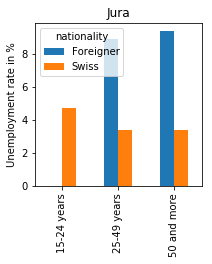

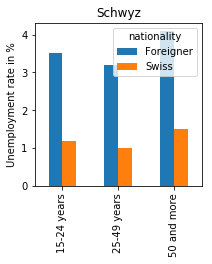

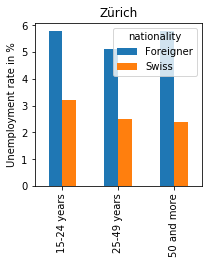

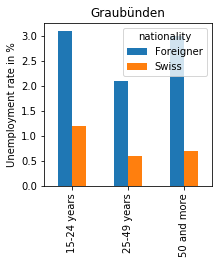

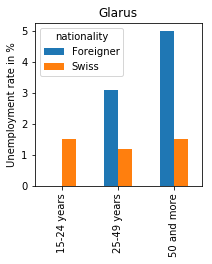

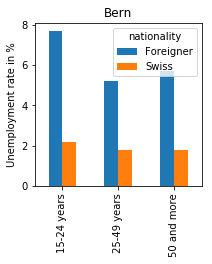

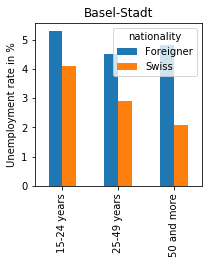

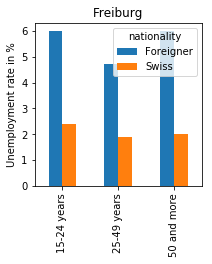

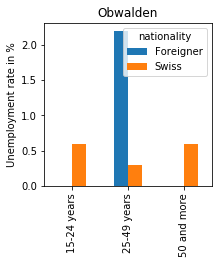

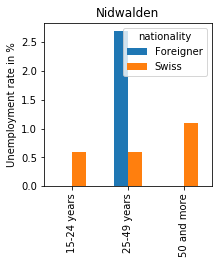

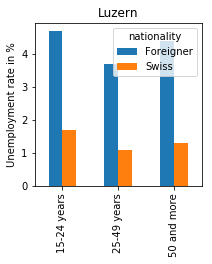

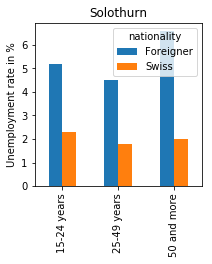

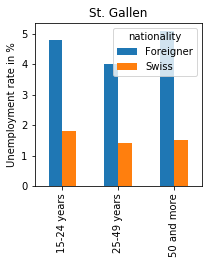

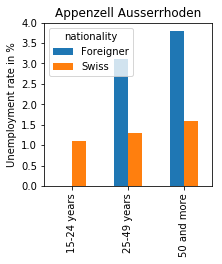

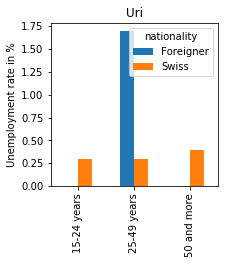

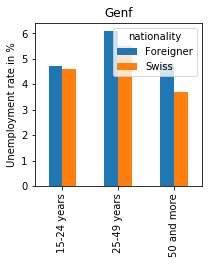

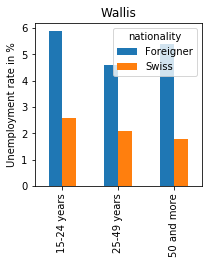

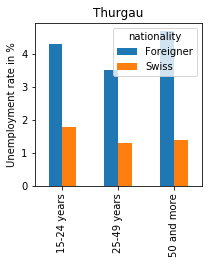

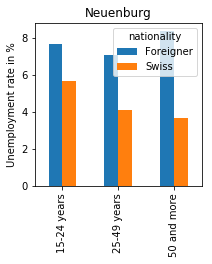

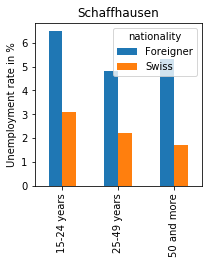

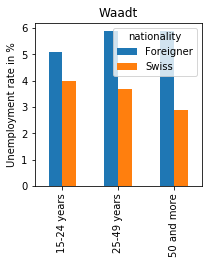

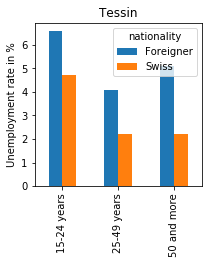

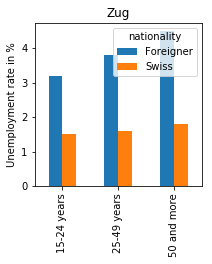

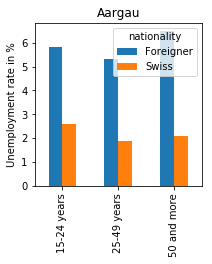

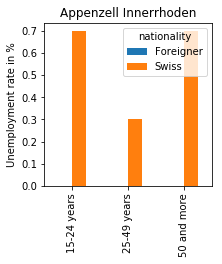

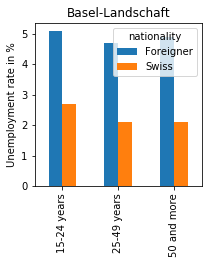

In [205]:
from itertools import cycle, islice
%matplotlib inline
import matplotlib.pyplot as plt
for c in cantons_german:
    df_grouped = df_nat_age[df_nat_age.canton == c].groupby(['category range', 'nationality'])['rate_09_2017'].mean()
    df_grouped = df_grouped.unstack()
    pl = df_grouped.plot(kind='bar', figsize=[3,3])
    pl.set_title(c)
    pl.set_ylabel('Unemployment rate in %')
    pl.set_xlabel('')

## Bonus 4

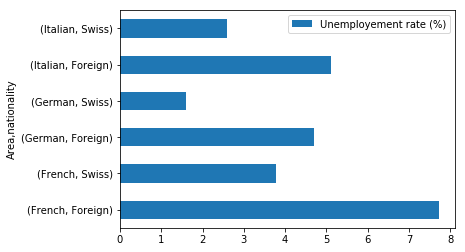

In [206]:
cantons_division = {
        'ZH': 'German',
        'BE': 'German',
        'LU': 'German',
        'UR': 'German',
        'SZ': 'German',
        'OW': 'German',
        'NW': 'German',
        'GL': 'German',
        'ZG': 'German',
        'FR': 'German',
        'SO': 'German',
        'BS': 'German',
        'BL': 'German',
        'SH': 'German',
        'AR': 'German',
        'AI': 'German',
        'SG': 'German',
        'GR': 'German',
        'AG': 'German',
        'TG': 'German',
        'TI': 'Italian',
        'VD': 'French',
        'VS': 'French',
        'NE': 'French',
        'GE': 'French',
        'JU': 'French'
           }
temp = df_nat.copy()
for index, row in temp.iterrows():
    temp.loc[index, 'Area'] = cantons_division[temp.at[index, 'Sign'][0]]

temp = temp.rename(columns={'rate_2017': 'Unemployement rate (%)'})

temp.loc[temp['nationality'] == 'Schweizer', 'nationality'] = 'Swiss'
temp.loc[temp['nationality'] == 'Ausländer', 'nationality'] = 'Foreign'
potatoesline = temp.copy()
potatoesline = potatoesline.groupby(['Area', 'nationality']).mean()
potatoesline.plot(kind='barh')

### Interpretation of the potatoes line data 
As we can see from the plot above, grouping the data using the speaking language of the cantons reveals differences in the unemployement rate of the cantons. In particular:
- the German speaking part of Switzerland obtains a really low unemployement rate both for Swiss and Foreign people compared to the French speaking part. 
- However in the German speaking part is also visible that the Foreign people unemployement rate is three times the unemployement rate of Swiss people.